# Capturing contributions in different 'brain modes'

In this notebook, I will simulate the modes described here:
- Toba, Monica N., Olivier Godefroy, R. Jarrett Rushmore, Melissa Zavaglia, Redwan Maatoug, Claus C. Hilgetag, and Antoni Valero-Cabré. 2019. **“Revisiting ‘brain Modes’ in a New Computational Era: Approaches for the Characterization of Brain-Behavioural Associations.”** Brain: A Journal of Neurology, November. https://doi.org/10.1093/brain/awz343.

The idea, as described in the above paper comes from an earlier work by Godfroy and colleagues in which they _"conceptualized the potential of four elementary typologies of brain-behaviour relationships named ‘brain modes’ (unicity, equivalence, association, summation) as building blocks able to describe the association between intact or lesionedbrain regions and cognitive processes or neurological deficits."_ 

In this work, Toba and co-workers revisted the idea and added a fifth mode called "mutual inhibition". It's a very nice concept for categorizing brain-behavior relationships so I thought I give MSA a try and see if I can capture these interactions.

In [7]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
# ---------
from core import msa, utils as ut
# ---------
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'GothamSSm'  # Will skip if you don't have Gotham typeface family
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 8
#---------
CM = 1 / 2.54
RED = '#F53A61'
SEED = 111

Although the original paper talks about two regions, here we go with some dummy regions and work with one to three regions. Keep it simple but more spicy! The regions of interest will be mostly 'a' and 'b' but once 'c' too.

In [8]:
regions = ['a','b','c','d','e','f','g','h']

## Modes:
Let's look at the modes first:

<img src="../images/modes.png"  width="800">

Each mode represents a type of interaction between two (or more) regions that causes some deficit in a cognitive/behavioral domain. Let's look at the parts describing these modes in the paper: (bolded parts are by me)

- **Unicity:** Unicity, could depict the functional contributions of **isolated nodes**, which are hardly present in the highly and intricately connected mammalian nervous systems. Thus, this mode has been theoretically hypothesized but remains to be documented clinically.


- **Equivalence:** The equivalence brain mode has been documented theoretically and also clinically. Indeed, in the original paper describing brain modes, single lesions localized at two different levels along the cortico-spinal tract were characterized as **equally responsible** for motor weakness.


- **Association:** The association brain mode has been identified theoretically but remains to be better documented clinically, as it requires rare-to-find patients with selective lesions damaging **multiple regions within the same network.** This mode was originally illustrated in patients with unilateral lenticulostriate lesions(Godefroy et al., 1992) showing executive function impairment **only when, additionally, they suffered an associated cortical infarct**.


- **Summation:** The summation mode has been documented both theoretically and clinically. For example, in language impairments, non-fluent aphasia was associated with lesions of putamen and surrounding structures while mutism was associated with **large lesion of the three frontal gyri and putamen**.


- **Mutual Inhibition:** [...]multivariate CART approaches originally used for their characterization failed to identify ‘paradoxical lesion cancellation’ effects,[...] This phenomenon described the **paradoxical improvement of performance deficits caused by a circumscribed lesion** thanks to a reversible or permanent suppression of activity in a second brain area interacting with the former.


So let's code them:

In [9]:
def unicity(complements):
    # Region 'a' is the only cause of the function.
    
    if set('a').issubset(complements):
        return 0  # simulates a total behavioral deficit.
    else:
        return 100 # otherwise, we're cool.


def equivalence(complements):
    # Function relies on one **or** the other region so lesioning either will produce a deficit.
    
    if set('a').issubset(complements) or set('b').issubset(complements):
        return 0
    else:
        return 100


def association(complements):
    # If **both** regions are damaged at the same time, there will be a problem.
    
    if set(['a','b']).issubset(complements):
        return 0
    else:
        return 100


def summation(complements):
    # Lesioning both will have a **bigger impact** compared to lesioning one, and it get's worst with three.
    
    if set(['a','b','c']).issubset(complements):
        return 30 # lesions add up and make larger impact on the performance.
    elif set(['a','b']).issubset(complements):
        return 60
    elif set('a').issubset(complements):
        return 90
    else:
        return 100


def mutual_inhibition(complements):
    # Lesioning one region produces deficit while lesioning another repairs it.
    
    if set('a').issubset(complements) and set('b').issubset(complements):
        return 100 # Paradoxically, two lesions = full performance
    
    elif set('a').issubset(complements):
        return 0 # lesioning either one is a bad idea
    elif set('b').issubset(complements):
        return 0
    
    else:
        return 100


Now let's loop through them, simulate, and calculate Shapley values of each element in these brain modes.

In [10]:
modes = [unicity, equivalence, association, summation, mutual_inhibition]

shapley_tables = dict.fromkeys([keys.__name__ for keys in modes])

for mode in modes:
    shapley_tables[mode.__name__], _, _ = msa.interface(elements=regions,
                                                        n_permutations=1_000,
                                                        objective_function=mode,
                                                        n_parallel_games=1,
                                                        random_seed = SEED)

And plotting stuff:

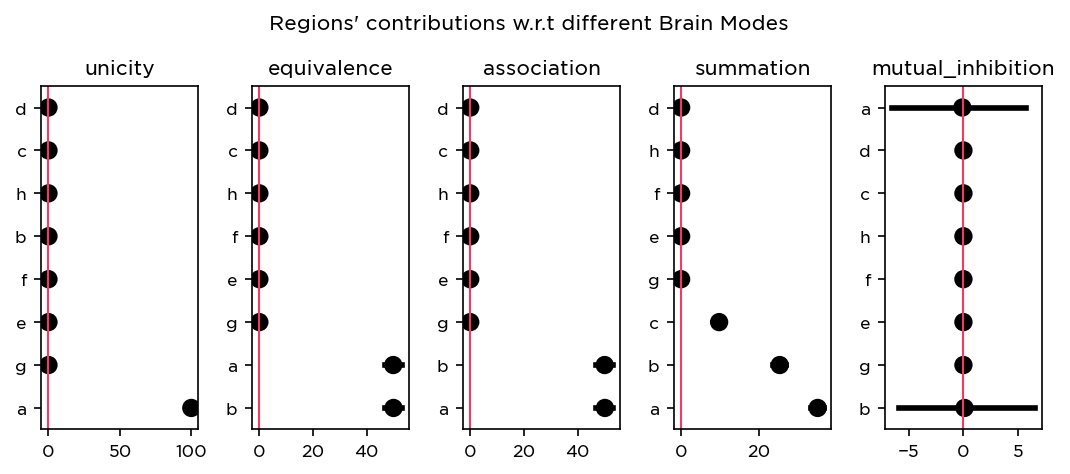

In [11]:
fig, axes = plt.subplots(1, 5,figsize=(18*CM,8*CM),dpi=150)
fig.suptitle("Regions' contributions w.r.t different Brain Modes")

for i, mode in enumerate(shapley_tables.keys()):
    
    axes[i].set_title(f'{mode}')
    
    dataset = ut.sorter(shapley_tables[mode])
    
    sns.pointplot(ax = axes[i], 
                  data = dataset, 
                  ci=95, 
                  join=False,
                  orient='h',
                  color='k')
    
    axes[i].axvline(linewidth=1, color=RED)
    
fig.tight_layout()

The interesting points for me are the negative Shapley value of region 'a' and 'b' in the mutual inhibition mode, and the indistinguishable contributions in equivalence and association modes.